**CHANDRACHUD GOWDA**

Spring 2023

CS 251/2: Data Analysis and Visualization

Project 6: Supervised learning

In [56]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 6) Supervised learning

The overall goal of this project is to implement an email spam filter to determine whether an email is spam (*spam*) or not (*ham*). You will implement and compare the performance of two supervised learning algorithms: **K Nearest Neighbors (KNN)** and **Naive Bayes**.

## Task 1: K Nearest Neighbors (KNN) Classifier

To start off the project, you will implement the **KNN classifier**, a bedrock, highly-versatile, nonparametric (i.e. *memory-based*) supervised learning algorithm. You will test out and experiment with KNN on a **multi-class spiral 2D dataset**.

### 1a) Load and visualize spiral data

- Below, load in both spiral datasets 1 (`spiral_train_1.csv`, `spiral_val_1.csv`) and 2 (`spiral_train_2.csv`, `spiral_val_2.csv`). Each training set has 4,000 samples and each validation set has 1,200 samples (*there is no test set for this development dataset*).
- Create a 2x2 grid plot showing the train and validation data side-by-side in each version of the dataset.
    - Be sure to label your subplots with informative titles (which datset are we looking at?).
    - Color-code the points based on their class.
    - Set the figure size to make everything clearly legible (not microscopic).

#### Format of spiral data

- Column 1: x coordinate of a 2D point (on a spiral).
- Column 2: y coordinate of a 2D point (on a spiral).
- Column 3: class. Which spiral arm does the point belong to? Labels: [0, 1, 2, 3]

In [57]:
spiral_1_train = np.loadtxt('data/spiral_train_1.csv', skiprows=1, delimiter=',')
spiral_1_val = np.loadtxt('data/spiral_val_1.csv', skiprows=1, delimiter=',')
spiral_2_train = np.loadtxt('data/spiral_train_2.csv', skiprows=1, delimiter=',')
spiral_2_val = np.loadtxt('data/spiral_val_2.csv', skiprows=1, delimiter=',')

spiral_1_train_y = spiral_1_train[:, 2]
spiral_1_val_y = spiral_1_val[:, 2]
spiral_2_train_y = spiral_2_train[:, 2]
spiral_2_val_y = spiral_2_val[:, 2]

spiral_1_train = spiral_1_train[:, :2]
spiral_1_val = spiral_1_val[:, :2]
spiral_2_train = spiral_2_train[:, :2]
spiral_2_val = spiral_2_val[:, :2]

print(f'Spiral 1 train {spiral_1_train.shape}, classes {spiral_1_train_y.shape}')
print(f'Spiral 1 validation {spiral_1_val.shape}, classes {spiral_1_val_y.shape}')
print(f'Spiral 2 train {spiral_2_train.shape}, classes {spiral_2_train_y.shape}')
print(f'Spiral 2 validation {spiral_2_val.shape}, classes {spiral_2_val_y.shape}')

Spiral 1 train (4000, 2), classes (4000,)
Spiral 1 validation (1200, 2), classes (1200,)
Spiral 2 train (4000, 2), classes (4000,)
Spiral 2 validation (1200, 2), classes (1200,)


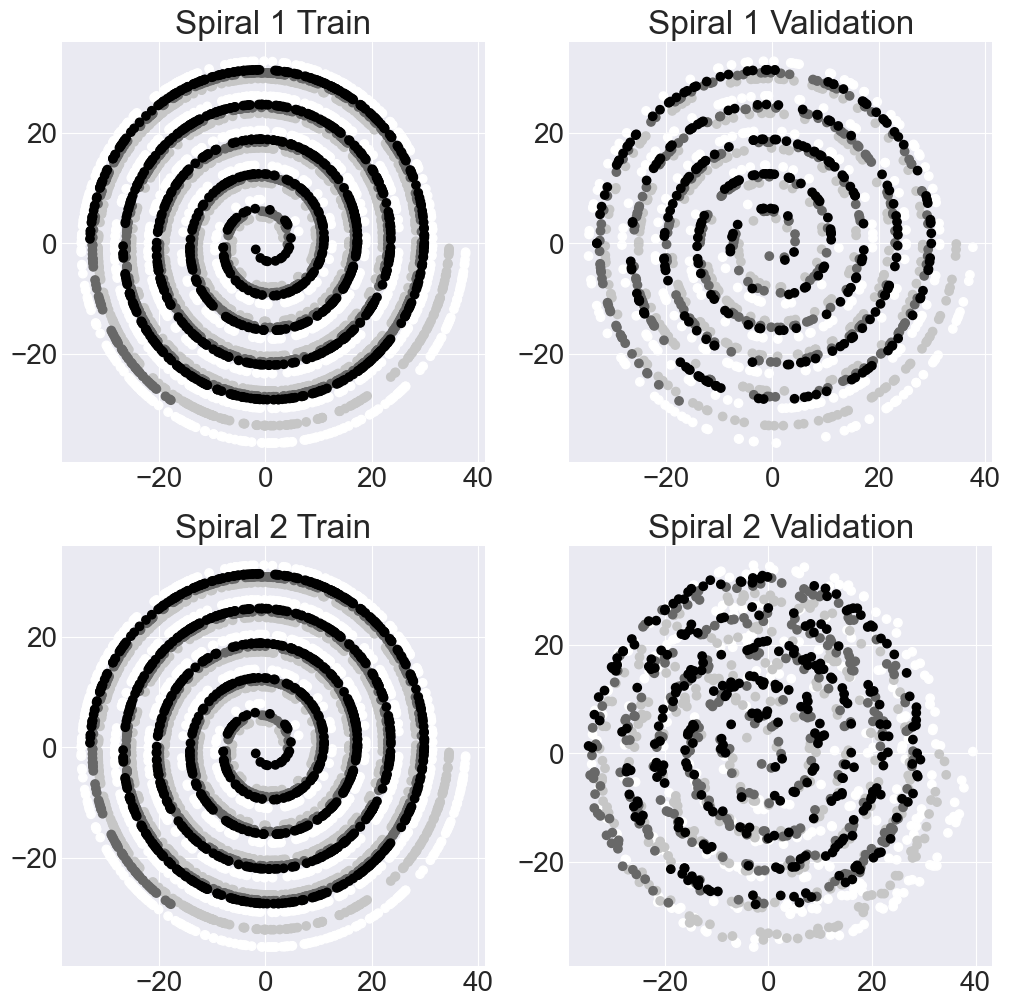

In [58]:
# Your plot here

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Spiral 1 train data
axs[0, 0].scatter(spiral_1_train[:, 0], spiral_1_train[:, 1], c=spiral_1_train_y)
axs[0, 0].set_title("Spiral 1 Train")

# Spiral 1 validation data
axs[0, 1].scatter(spiral_1_val[:, 0], spiral_1_val[:, 1], c=spiral_1_val_y)
axs[0, 1].set_title("Spiral 1 Validation")

# Spiral 2 train data
axs[1, 0].scatter(spiral_2_train[:, 0], spiral_2_train[:, 1], c=spiral_2_train_y)
axs[1, 0].set_title("Spiral 2 Train")

# Spiral 2 validation data
axs[1, 1].scatter(spiral_2_val[:, 0], spiral_2_val[:, 1], c=spiral_2_val_y)
axs[1, 1].set_title("Spiral 2 Validation")

plt.show()


### 1b) Implement KNN

Implement the following methods in `knn.py`. Test relevant methods using the test code below.

- Constructor
- `train(data, y)`: Train the KNN classifier on the data `data`, where training samples have corresponding class labels in `y`.
- `predict(data, k)`: Use the trained KNN classifier to predict the class label of each test sample in `data`. Determine class by voting: find the closest `k` training exemplars (training samples) and the class is the majority vote of the classes of these training exemplars.
- `accuracy(y, y_pred)`: Compute percent correct given true data labels `y` and algorithm predicted labels `y_pred`. 

In [59]:
from knn import KNN

#### Test: Accuracy

In [60]:
np.random.seed(0)
test_y = np.random.randint(low=0, high=11, size=(50,))
test_y_pred = np.random.randint(low=0, high=11, size=(50,))

classifier = KNN(num_classes=0)
acc = classifier.accuracy(test_y, test_y_pred)
print(f'Test accuracy is {acc} and should be 0.06.')

Test accuracy is 0.06 and should be 0.06.


#### Test: 1-KNN

In [61]:
n_classes = 4
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)

k = 1
spiral_1_y_pred = classifier.predict(spiral_1_train, k)
acc = classifier.accuracy(y=spiral_1_train_y, y_pred=spiral_1_y_pred)
print(f'Your accuracy with K=1 is {acc} and should be 1.0')

Your accuracy with K=1 is 1.0 and should be 1.0


**Question 1:** Explain why in the above test, the accuracy must be 100%.

**Answer 1:** In the above test, the KNN classifier is trained and tested on the same dataset, which is spiral_1_train. Therefore, when the classifier is asked to predict the classes of the same datapoints that were used for training, it should always predict the correct class. As a result, the accuracy of the classifier must be 100%.




#### Test 2-KNN

*Note: The below test code assumes that you resolve voting ties with the class that has a lower index. There is a numpy function that you may feel inclined to use (or not!) that handles this automatically.*

In [62]:
n_classes = 4
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)

k = 2
spiral_1_y_pred = classifier.predict(spiral_1_val, k)
acc = classifier.accuracy(y=spiral_1_val_y, y_pred=spiral_1_y_pred)
print(f'Your accuracy with K=2 is {acc:.2f} and should be 0.88')

true_test_y = np.array([2., 2., 2., 2., 2., 3., 2., 2., 3., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 3., 3., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 3., 2., 2.,
       2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 3., 2., 2., 2., 3., 3., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

print(f'The mismatches between your predicted class of validation samples with indices 750-900 and the expected values are\n{np.where(true_test_y != spiral_1_y_pred[750:900], 1, 0)}')
print('Seeing all 0s means everything seems to be working great!')

Your accuracy with K=2 is 0.88 and should be 0.88
The mismatches between your predicted class of validation samples with indices 750-900 and the expected values are
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Seeing all 0s means everything seems to be working great!


### 1c) Find the best `k`

- Below, "script" your `predict` method on both spiral datasets 1 and 2. Compute the accuracy on the respective test sets with many different values of `k`.
- Create two well-labeled plots, one for each spiral dataset, showing the accuracy for many different `k` values.

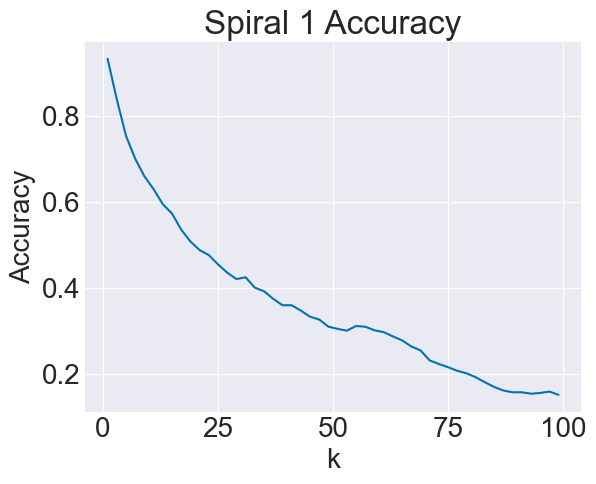

In [63]:

# - Below, "script" your `predict` method on both spiral datasets 1 and 2. Compute the accuracy on the respective test sets with many different values of `k`.
# - Create two well-labeled plots, one for each spiral dataset, showing the accuracy for many different `k` values.

# Your code here

def plot_accuracy(k_values, accuracies, title):
    plt.plot(k_values, accuracies)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

k_values = np.arange(1, 100, 2)
accuracies = []

for k in k_values:
    spiral_1_y_pred = classifier.predict(spiral_1_val, k)
    acc = classifier.accuracy(y=spiral_1_val_y, y_pred=spiral_1_y_pred)
    accuracies.append(acc)

plot_accuracy(k_values, accuracies, "Spiral 1 Accuracy")

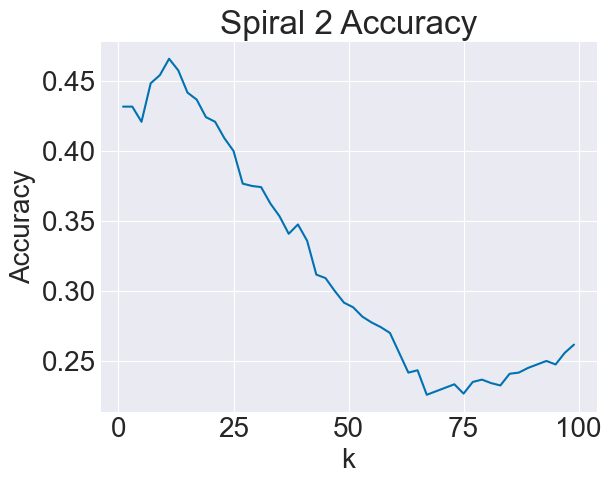

In [64]:
accuracies = []

for k in k_values:
    spiral_2_y_pred = classifier.predict(spiral_2_val, k)
    acc = classifier.accuracy(y=spiral_2_val_y, y_pred=spiral_2_y_pred)
    accuracies.append(acc)

plot_accuracy(k_values, accuracies, "Spiral 2 Accuracy")

**Question 2:** What is the `k` that results in the highest accuracy on each spiral dataset?

**Question 3:** Give at least one "good" reason why the accuracies are so different across the datasets. (*Hint: look at the data*)

**Question 4:** Give at least one "good" reason why the best `k` values are so different across the datasets.

**Question 5:** Is it a good idea to always set `k` to one of these values when working with another dataset?

**Answer 2:** For Spiral 1, k = 1. For Spiral 2, k = 11

**Answer 3:** One possible "good" reason why the accuracies are so different across the datasets is due to the characteristics of the data themselves. For example, Spiral 1 dataset may have more distinct and well-separated clusters of data points for each class, making it easier for the KNN algorithm to correctly classify the testing data points. In contrast, Spiral 2 dataset may have more overlapping and chaotic clusters, which makes it harder for the algorithm to accurately classify the testing data points.

**Answer 4:**  One possible "good" reason why the best k values are so different across the datasets is also due to the characteristics of the data themselves. For example, when the clusters of data points for each class are well separated (like in Spiral 1), using a smaller value of k (such as 1) may be more effective because it allows the algorithm to focus on the nearest neighbor, which is likely to belong to the same class. However, when the clusters are more chaotic and overlapping (like in Spiral 2), using a larger value of k may be more effective because it allows the algorithm to take into account a larger number of neighbors, which can help in determining the correct class for the testing data point.

**Answer 5:** No, it is not a good idea to always set k to one of these values when working with another dataset. The best value of k depends on the characteristics of the data and the problem at hand, and may vary for different datasets. Therefore, it is important to perform a thorough analysis and experimentation to determine the optimal value of k for a specific dataset and problem.

### 1d) Visualize class boundaries

- Implement `plot_predictions` in `knn.py` to visualize how different regions of the (2D) dataspace would be classified. In this visualization, use four discrete colors to represent each of the classes. For example, if KNN would classify (x, y) = (10, 10) to spiral 2, you would color that region blue (for example). You will repeat this for lots of different regularly spaced x,y points to get a better picture of the regions that would be predicted to belong to different classes.
- For spiral dataset 1 and 2, plot the class boundaries for the k best value determined above.

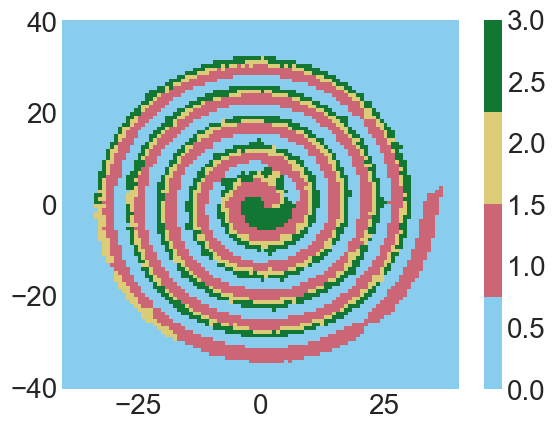

In [65]:
classifier.predict(spiral_1_val, k)
classifier.accuracy(y=spiral_1_val_y, y_pred=spiral_1_y_pred)
classifier.plot_predictions(1, 100)
plt.show()

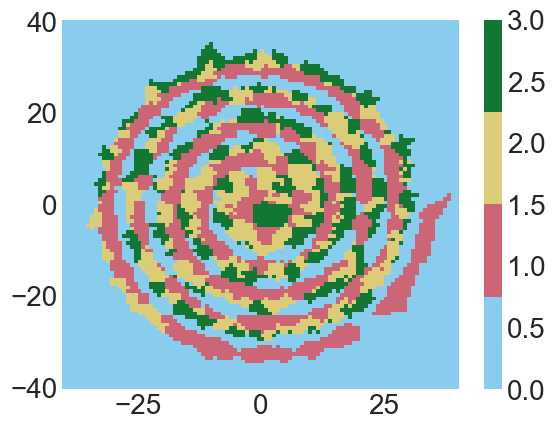

In [66]:
classifier.predict(spiral_2_val, k)
classifier.accuracy(y=spiral_2_val_y, y_pred=spiral_2_y_pred)
classifier.plot_predictions(11, 100)
plt.show()

**Question 6:** Why could visualizing the class boundaries be useful?

**Answer 6:** It is because we may want to go beyond the numerical prediction (of the class or of the probability) and visualize the actual decision boundary between the classes, which can give us a clear idea of the distribution and disparity of each class

## Task 2: Spam email preprocessing pipeline

Before you can build a spam email filter, you need to transform the email data into a suitable format so that KNN or other supervised learning algorithms can process them (this is called **preprocessing**).

In this project, you will work with the **Enron email dataset**, a large datset consisting of ~34,000 emails. Enron is an energy company that famously went bankrupt in the early 2000s after committing massive accounting fraud (more info: https://en.wikipedia.org/wiki/Enron). The US government seized company emails during their investigation and they were released to the public much later and nowadays is a commonly used datset in machine learning. 

Your eventual goal will be to train a supervised learning algorithm on some of the emails and predict whether the remaining ones are spam or not.

But first...onto the preprocessing!

### Overall preprocessing strategy

We need to turn each email's text into something an algorithm can process (**features**). We will use a simple type of feature: **bag of words counts**. That is, we will reduce an email into a vector of how many times words appeared in it.

*Problem:* There are too many words across all the emails. Processing the counts in each email would take too long. For example, there are more than 40,000 words across all the emails. If we were trying to predict whether 1,000 emails are spam or not, we would need to build a `1000 x 40000` matrix (count each of the 40,000 words in each of the 1,000 emails), which would take a very long time to process by the supervised learning algorithm. 

A work-around that works quite well is to restrict ourselves to the most frequent $W$ words in the email dataset. You can experiment with how many words to include (e.g. as an extension), but for concreteness we will set this $W=200$ in the core project. In the above example, we can then process `1000 x 200` matrix much more quickly.

### 2a) Determine email word frequency

The large size of the enron email datset makes the debugging process cumbersome. In situations like this, it is common to work with a **development dataset** — a mini version of the full dataset that is much faster to work with. The enron dev datset has 2 ham emails and 3 spam emails. 

- Download and extract the **Enron dev** emails. You should see a base `enron` folder, with `spam` and `ham` subfolders (these are the 2 classes), and documents in each with the raw email text. There should be 2 files in the ham folder and 3 files in the spam folder.
- In `email_preprocessor.py` implement `count_words(email_path)` to build up a python dictionary of all the words in the dataset (keys) and their associated counts (values).
- Write `find_top_words(word_freq)` to parse the dictionary and determine the top $W$ words.

In [72]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [73]:
word_freq, num_emails = epp.count_words(email_path='data/enron_dev/')

In [74]:
print(f'You found {num_emails} emails in the datset. You should have found 5.')

You found 5 emails in the datset. You should have found 5.


In [75]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"You found {len(top_words)}/19 words.")
print(f"Your top 2 words are\n{top_words[:2]}\nand they should be\n['subject', 'you']")
print(f"The counts of all the words are\n{top_counts}\nand they should be\n[5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]")
print(f"The 19 words should are\n{top_words}\n and they should be \n['subject', 'you', 'get', 'that', 'new', 'car', 'now', 'can', 'be', 'smart', 'love', 'ecards', 'christmas', 'tree', 'farm', 'pictures', 're', 'rankings', 'thank']\nwith the last 17 words in any order (because their counts are tied)")

You found 19/19 words.
Your top 2 words are
['subject', 'you']
and they should be
['subject', 'you']
The counts of all the words are
[5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
and they should be
[5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The 19 words should are
['subject', 'you', 'get', 'that', 'new', 'car', 'now', 'can', 'be', 'smart', 'love', 'ecards', 'christmas', 'tree', 'farm', 'pictures', 're', 'rankings', 'thank']
 and they should be 
['subject', 'you', 'get', 'that', 'new', 'car', 'now', 'can', 'be', 'smart', 'love', 'ecards', 'christmas', 'tree', 'farm', 'pictures', 're', 'rankings', 'thank']
with the last 17 words in any order (because their counts are tied)


### 2b) Make feature vectors based only on the top word counts

- Implement `make_feature_vectors`: Go back through the email folder structure and parse each email again. Now only count the frequency of words that are in the top $W$ word list. Keep track of whether each of these feature vectors are associated with a spam or not spam email.

In [76]:
hard_code_words = ['subject', 'you', 'get', 'that', 'new', 'car', 'now', 'can', 'be', 'smart', 'love', 'ecards', 'christmas', 'tree', 'farm', 'pictures', 're', 'rankings', 'thank']
features, y = epp.make_feature_vectors(hard_code_words, num_emails, email_path='data/enron_dev/')

In [77]:
firstSpamWordCounts = np.array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


print(f'Your matrix of features has shape:\n{features.shape}\nand it should be\n(5, 19).')
print(f'Your class label vector has shape:\n{y.shape}\nand it should be\n(5,).')
print(f"Make sure your features have 0's and 1's in every row")
print(features)
print('\nBelow, one number should be 3, the other should be 2.')
print(f'Number of emails of class 0: {np.sum(y == 0)}\nNumber of emails of class 1: {np.sum(y == 1)}')

inds = np.arange(len(features))
test_ind = inds[np.all(firstSpamWordCounts == features, axis=1)]
print(f'\nYour vector for 2958.2004-11-03.GP.spam.txt matches expected counts?\n{len(test_ind) == 1}\n')

Your matrix of features has shape:
(5, 19)
and it should be
(5, 19).
Your class label vector has shape:
(5,)
and it should be
(5,).
Make sure your features have 0's and 1's in every row
[[1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]

Below, one number should be 3, the other should be 2.
Number of emails of class 0: 2
Number of emails of class 1: 3

Your vector for 2958.2004-11-03.GP.spam.txt matches expected counts?
True



### 2c) Make train and test splits of the dataset

Your matrix of features is for the entire dataset. We can't train the classifier on all these because then we won't have any emails left over to see how well your model's ability to discriminate spam/ham email generalizes to emails not seen during training!

Implement `make_train_test_sets` to divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [78]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [79]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (4, 19), classes (4,)\nTest (1, 19), classes (1,)')

Shapes for train/test splits:
Train (4, 19), classes (4,)
Test (1, 19), classes (1,)

They should be:
Train (4, 19), classes (4,)
Test (1, 19), classes (1,)
